<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# CNNs to Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordigns
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [97]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --single-branch --branch cboulay/macaque_pfc --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta1
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell, reset_keras
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [98]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'monkey_pfc'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' )} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one session
TODO: Explain data.

### Load the data
Let's use a helper function from the repo to load the data.
You can see the code for `load_macaque_pfc` [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/utils/fileio.py)
(TODO: Point to line number).

In [99]:
from data.utils.fileio import load_macaque_pfc

# SESS_ID = 'sra3_1_j_050_00'
SESS_ID = 'sra3_1_m_074_0001'
X, Y, ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spikerates', zscore=True)
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 884 trials, 171 timestamps (-0.2 to 1.5 at 100.0 Hz), 32 channels


### Get baseline accuracy

Next we will use "shallow" machine learning techniques to train a model to predict intended saccade direction.

#### LDA
A good first approach would be to use multi-class LDA. Given the number of features (timestamps * channels), LDA is likely to over-fit. We can use regularization. However, sk-learn's LDA regularization relies on the `'eigen'` solver which can run out of memory when operating on very large feature matrices. You can try the cell below, but it may not work depending on how many channels and timestamps we have. sk-learn probably has other mechanisms to regularize LDA, but we'll instead use a different ML algorithm in a couple cells below.

In [4]:
# Depending on data shape you may run out of memory here.
# Either way, you can achieve the same result using a different method in the next code cell.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10, shuffle=True)

y_preds = []
y_true = []
fold_ix = 0
for trn, tst in splitter.split(X, Y):
    fold_ix += 1
    print("Fold {}".format(fold_ix))
    lda.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(lda.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 83.35517693315859


#### Logistic Regression
Instead of LDA, we'll use Logistic Regression. sk-learn's regularization scheme for logistic regression is more robust than for LDA. This is a CPU-intensive task and is a bit slow on Colab.

Note: Though 'Logistic Regression' has 'regression' in the name, it's actually a classification algorithm.

We start by using all available time points to try to get the best accuracy.

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 500
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 62.66968325791855


The accuracy using shallow methods is around 60% for monkey M and 81-83% for monkey J. Is this good?

There are 8 different classes in the data. Chance accuracy _should_ be 12.5%. However, condition-pairs were presented in blocks, so a classifier that could simply identify "block" (e.g. by heavily weighting transient neurons) would achieve ~50% accuracy. The best way to know is to run the classifier again using only data available before any stimulus was presented, and again using only data after the stimulus was presented but before the cue indicated the correct stimulus was presented.

Next we run the classification using only the data from before the targets were presented.

In [101]:
args['max_iter'] = 1000
model = LogisticRegression(**args)
b_times = ax_info['timestamps'] < 0
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-trial data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-trial data only: 27.828054298642535%


Then we run it again using only the data before the cues appeared, including the 0.25 s after the targets appeared.
At this point, the monkey knows the two potential target locations. He/she will know which is the cue and which is the target only after cue onset.

In [102]:
b_times = ax_info['timestamps'] < 0.250
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-cue data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-cue data only: 41.6289592760181%


Without any stimulus information at all, decoder accuracy was 29-34%. Including neural data after the target-distractor pair appeared, but before the cue appeared (i.e. before the monkey had enough information to know the correct target), decoder accuracy was 39-47%. Our decoder using all of the data up to the imperative cue had an accuracy of 60% in one dataset and 81% in another, which is much higher than these 'baseline' values. These results suggest that the model learned something about the relationship between neural activity and intended saccade direction.

### Prepare data for deep learning

In [103]:
from sklearn.model_selection import train_test_split

def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        x_dat = tf.expand_dims(x_dat, -1)  # Prepare as an image, with only 1 colour channel.
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

## Create our model
Our model objective is to transform timeseries data into probabilities of each class.



In [104]:
# EEGNet-like model. https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
# See explanation of depthwise and separable convs here:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_model(T, C, aug_offset=30,
               n_temporal_filters=38,
               kern_length_1=32, downsamp_1=2,  # 48, 2
               D=1,
               n_pointwise_filters=10, kern_length_2=16, downsamp_2=2,  # 24, 2
               norm_rate=0.35, dropout_rate=0.4, l2_reg=0.00001):
    """
    Create EEGNet-like model.
    :param T: Number of time-steps in input
    :param C: Number of channels in input
    :param aug_offset: maximum number of samples to shift training data for augmentation.
    :param n_temporal_filters: We need enough temporal filters to capture all within-channel patterns * scales.
     e.g. oscillations at different freqs, evoked potentials, transition between bistable firing rates.
    :param kern_length_1: Temporal filter kernel length should be long enough to capture slow features.
     e.g. 2 Hz oscillations or long ERPs req ~500 msec
    :param downsamp_1: First downsample factor. If we started with 2-seconds at 40 Hz, a 4x downsample yields 2-seconds at 10-Hz.
    :param D: Spatial_filters per temporal filter.
    :param n_pointwise_filters: Output of transformation across (n_temporal_filters * D filters) filters
    :param kern_length_2: Length of kernel for second time-domain convolution.
    :param downsamp_2:
    :param norm_rate: kernel_constraint max_norm parameter in final Dense layer.
    :param dropout_rate:
    :param l2_reg:
    :return: model
    """

    model = tf.keras.models.Sequential([
        # 2-D filter has len=1 in the 'space'/'channels' dimension. Effectively the same filter is used in all channels.
        layers.Conv2D(n_temporal_filters, (kern_length_1, 1), padding='valid',
                      input_shape=(T - aug_offset, C, 1),
                      kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                      use_bias=False),
        layers.BatchNormalization(axis=1),
        # First layer yields output of a bank of time-domain filters.
        # Next we apply spatial filters (1, C). There are D spatial filters for each temporal filter.
        layers.DepthwiseConv2D((1, C), use_bias=False,
                               depth_multiplier=D,
                               kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_constraint=max_norm(1.)),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_1, 1)),
        layers.Dropout(dropout_rate),
        
        layers.SeparableConv2D(n_pointwise_filters, (kern_length_2, 1), padding='valid',
                               use_bias=False),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_2, 1)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(8, kernel_constraint=max_norm(norm_rate)),
        layers.Activation('softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

model = make_model(X.shape[1], X.shape[2])
model.summary()
reset_keras(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 32, 38)       1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 110, 32, 38)       440       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 110, 1, 38)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 1, 38)        440       
_________________________________________________________________
activation (Activation)      (None, 110, 1, 38)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 55, 1, 38)         0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 1, 38)         0

### Train the model
We use 100 epochs which is probably overkill for this particular dataset.
However, we've put in some guards against over-fitting so we might still expect this to perform well on the validation set.

In [105]:
N_SPLITS = 10
BATCH_SIZE = 10
MAX_OFFSET = 30
N_EPOCHS = 100

splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
split_ix = 0
best_val_accs = []
hists = []
for trn, tst in splitter.split(X, Y):
    print("Starting split {}".format(split_ix))
    
    # Get the training/testing data for this split.
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    # Create new model
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET)

    # Callback to save only the best (highest validation accuracy) model weights during training.
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(split_ix))),
            save_best_only=True,
            monitor='val_accuracy',
            verbose=0)
    ]
    
    # Train model
    history = model.fit(x=ds_train,  
                        epochs=N_EPOCHS, 
                        validation_data=ds_valid,
                        callbacks=callbacks,
                        verbose=0)
    hists.append(history.history)
    
    bva = 100*max(history.history['val_accuracy'])
    print("Split {}: Best validation accuracy {}%".format(split_ix, bva))
    best_val_accs.append(bva)
    split_ix += 1
    reset_keras(model)

print("%.2f%% (+/- %.2f%%)" % (np.mean(best_val_accs), np.std(best_val_accs)))

best_path = datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(np.argmax(best_val_accs)))
best_path.replace(datadir / 'converted' / (SESS_ID + '_model_best_all.h5'))

# Download 'best' model anytime with
# files.download(datadir / 'converted' / (SESS_ID + '_model_best_all.h5'))

Starting split 0
Split 0: Best validation accuracy 76.0869562625885%
185540
Starting split 1
Split 1: Best validation accuracy 73.62637519836426%
185535
Starting split 2
Split 2: Best validation accuracy 67.77777671813965%
185535
Starting split 3
Split 3: Best validation accuracy 66.29213690757751%
185535
Starting split 4
Split 4: Best validation accuracy 70.78651785850525%
185535
Starting split 5
Split 5: Best validation accuracy 71.59090638160706%
185535
Starting split 6
Split 6: Best validation accuracy 71.59090638160706%
185535
Starting split 7
Split 7: Best validation accuracy 66.66666865348816%
185535
Starting split 8
Split 8: Best validation accuracy 70.9302306175232%
185535
Starting split 9
Split 9: Best validation accuracy 70.23809552192688%
185535
70.56% (+/- 2.89%)


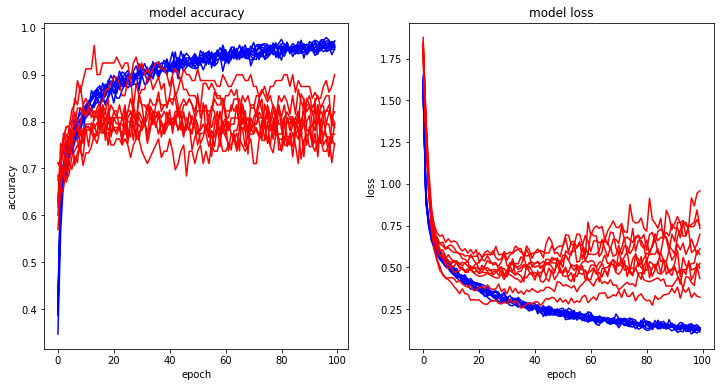

In [41]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(np.vstack([_['accuracy'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_accuracy'] for _ in hists]).T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(np.vstack([_['loss'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_loss'] for _ in hists]).T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~81% in two datasets. Using the EEGNet CNN, we achieve 72% and 86%. The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [42]:
# Load the 'best' model from disk.
from tensorflow.keras.models import load_model
model = load_model(datadir / 'converted' / (SESS_ID + '_model_best_all.h5'))
# model.summary()

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

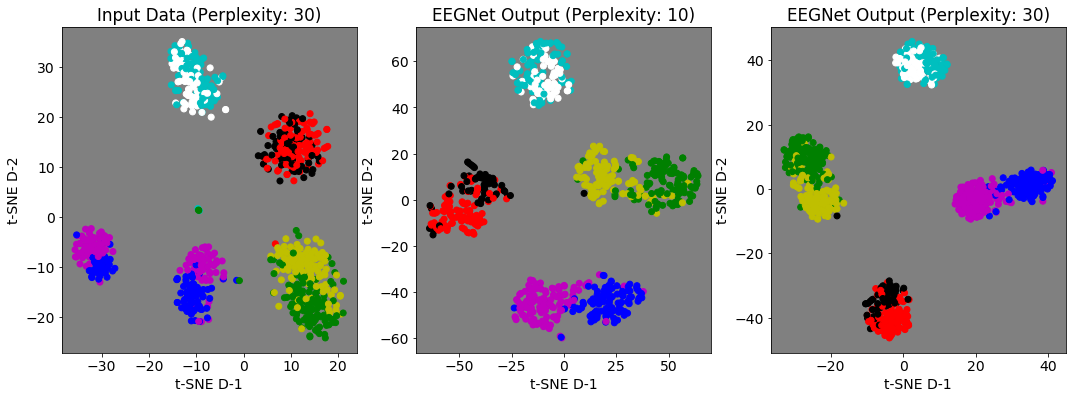

In [96]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
TEST_PERPLEXITY = [10, 30]
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(18, 6), facecolor='white')
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Perplexity: {})'.format(perplexity))
    ax = plt.gca()
    ax.set_facecolor('gray')

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY[-1], title='Input Data')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -3
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = truncated_model(X[:, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None])

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(flattened_output)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, Y.ravel()+1, perplexity, title='EEGNet Output')

fig.savefig(str(datadir / 'converted' / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

### First convolutional layer
The first convolutional layer is simply performing time-domain convolution. Interpreting this layer is similar to visualizing filter characteristics.

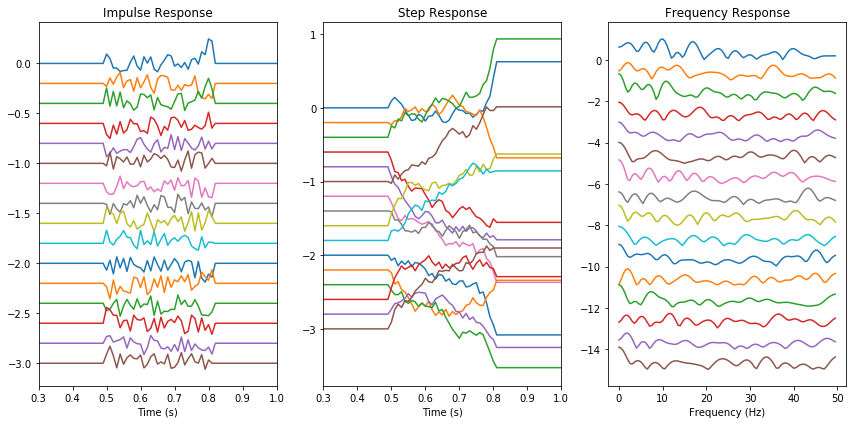

In [64]:
import scipy.signal

filters = np.squeeze(model.layers[0].get_weights()[0])
t = ax_info['timestamps']

fig = plt.figure(figsize=(12, 6), facecolor='white')

# Impulse response
impulse = np.zeros_like(t)
impulse[int(len(t)//2)] = 1.0
plt.subplot(1, 3, 1)
for filt_ix, filt_coeff in enumerate(filters.T):
    imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
    plt.plot(t, imp_conv - 0.2*filt_ix)
plt.xlim((0.3, 1.0))
plt.xlabel('Time (s)')
plt.title('Impulse Response')

# Step response
step = np.zeros_like(t)
step[int(len(t)//2):] = 1.0
plt.subplot(1, 3, 2)
for filt_ix, filt_coeff in enumerate(filters.T):
    step_response = scipy.signal.convolve(step, filt_coeff, 'same')
    plt.plot(t, step_response - 0.2*filt_ix)
plt.xlim((0.3, 1.0))
plt.xlabel('Time (s)')
plt.title('Step Response')

plt.subplot(1, 3, 3)
for filt_ix, filt_coeff in enumerate(filters.T):
    f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
    plt.plot(f, np.abs(resp) - filt_ix)
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

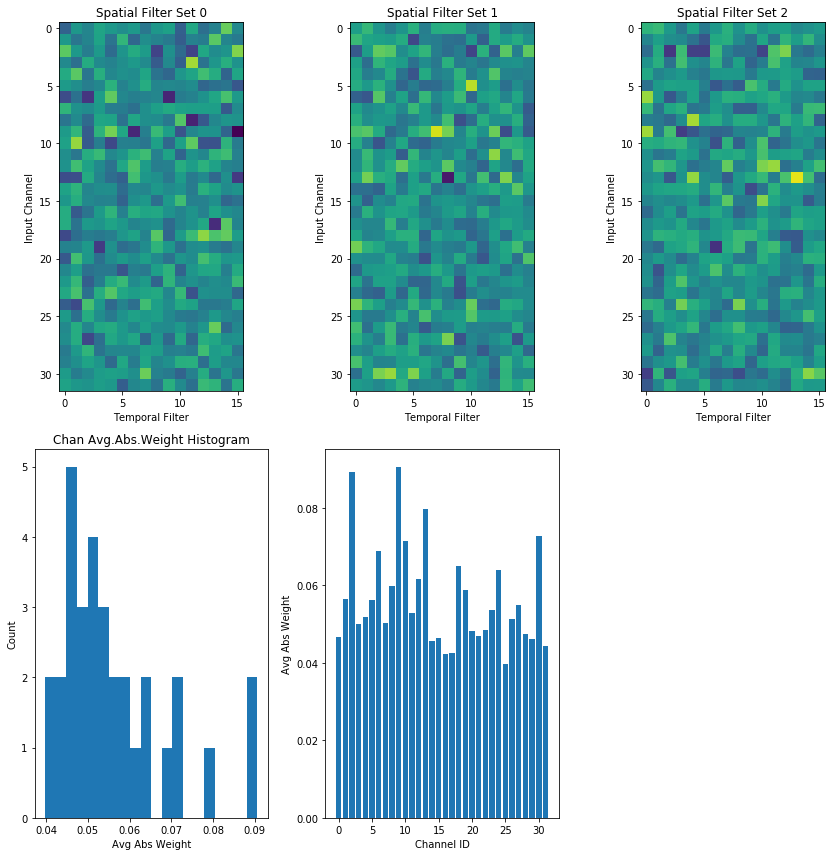

In [65]:
spatial_filter = np.squeeze(model.layers[2].get_weights()[0])
D = spatial_filter.shape[-1]
sp_dim = int(np.ceil(np.sqrt(D)))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12), facecolor='white')
for depth_ix in range(D):
    plt.subplot(sp_dim, sp_dim+1, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

avg_abs_weight = np.mean(np.mean(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_dim, sp_dim+1, D+1)
plt.hist(avg_abs_weight, 20)
plt.xlabel('Avg Abs Weight')
plt.ylabel('Count')
plt.title('Chan Avg.Abs.Weight Histogram')

plt.subplot(sp_dim, sp_dim+1, D+2)
plt.bar(np.arange(spatial_filter.shape[0]), avg_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Avg Abs Weight')

plt.tight_layout()
plt.show()

ch_ids = np.argsort(avg_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

# Maximum activations

For the remaining layers, it's difficult to conceptualize what data they represent simply by looking at their weights.
A more useful representation is to visualize an input that would maximize activation of a given filter. How do we do that?

Remembering back to the manual step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function. Now we know the weights but we want to find the _inputs_ that _maximize_ some other function related to the activation (a.k.a. output) of a filter. The new functions isn't really a 'loss', but we're going to use the same training framework so we'll hijack the loss function. A common loss function for this task is to simply take the Mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to modify the input (i.e., step the input up the gradients). Repeat with the new input until we have an input that maximizes our 'loss'.

In [ ]:
from tensorflow.keras import backend as K
LAYER_IX = 4
FILTER_IX = 0
N_STEPS = 200

max_model = tf.keras.Model(model.input, model.layers[LAYER_IX].output[:, :, :, FILTER_IX])
input_data = tf.convert_to_tensor(np.random.randn(*X.shape[1:]).astype(np.float32)[None, :, :, None])
for step_ix in range(N_STEPS):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        filter_act = max_model(input_data)
        loss_value = K.mean(filter_act)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    input_data += grads
print(loss_value.numpy())

In [ ]:
max_activation = input_data.numpy()[0]
plt.plot(max_activation[:, ch_ids[:3]])
plt.show()

Let's plot filter activation maximization signals for ~4 filters from each of the CNN layers.
This uses a [helper function from the repository](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/indl/cnn_helper_1D.py#L77-L149).

In [ ]:
from indl.cnn_helper_1D import visualize_layer, _stitch_filters
layer_idx = 10  # [2, 6, 10, 14]
max_acts = visualize_layer(model, layer_idx,
                           upsampling_steps=1, upsampling_factor=1,
                           filter_range=(0, 20),
                           output_dim=(701, model.get_input_shape_at(0)[-1]))
stitched_data = _stitch_filters(max_acts)

import matplotlib.pyplot as plt

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))

fig = plt.figure(figsize=(10, 6))
for chan_ix in ch_ids[:3]:
    plt.plot(stitched_data[:, :, chan_ix], color=next(colour_codes))
plt.show()

### Class Activation Maximization
If we extend our reasoning from filter activations down to the very last layer, and we choose a 'loss' that maximizes one class and minimizes the others, we can plot maximization signals for each of the 3 output classes.

In [ ]:
layer_idx = 20
# When processing softmax classification layer,
# second last dense layer should be converted from relu to linear.
if (layer_idx == len(model.layers) - 1) and (model.layers[-2].activation != tf.keras.activations.linear):
    model.layers[-2].activation = tf.keras.activations.linear
    import tempfile
    # Save and load the model to actually apply the change.
    tmp_path = Path(tempfile.gettempdir()) / (next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(str(tmp_path))
        model = load_model(str(tmp_path))
    finally:
        tmp_path.unlink()

In [ ]:
from indl.cnn_helper_1D import visualize_layer, _stitch_filters
max_acts = visualize_layer(model, layer_idx, loss_as_exclusive=True,
                           upsampling_steps=1, upsampling_factor=1,
                           filter_range=(0, 10),
                           output_dim=(701, model.get_input_shape_at(0)[-1]))
stitched_data = _stitch_filters(max_acts, n=2, sort_by_activation=False)

import matplotlib.pyplot as plt

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))

fig = plt.figure(figsize=(8, 5))
for chan_ix in ch_ids[:3]:
    plt.plot(stitched_data[:, :, chan_ix], color=next(colour_codes))
plt.show()

### Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
N_TRIALS = 9
test_class = 'ISI'
classes, y = np.unique(Y, return_inverse=True)
trial_ids = np.where(y == classes.tolist().index(test_class))[0]

losses_grads = []
for tr_id in trial_ids:
    input_data = tf.convert_to_tensor(X[tr_id, :, :].astype(np.float32)[None, :, :])
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        class_proba = model(input_data)
        loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    losses_grads.append((loss_value, grads))

In [ ]:
loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.concatenate([_[1].numpy() for _ in losses_grads], axis=0)
re_ix = np.argsort(loss_vals)
_x = X[trial_ids][re_ix][:3]
_masks = grad_vals[re_ix][:3]

for tr_ix in range(3):
    plt.subplot(3, 1, tr_ix + 1)
    plt.plot(_x[tr_ix, :, ch_ids[0]])
    ax2=plt.twinx()
    ax2.plot(_masks[tr_ix, :, ch_ids[0]], 'k')

### Class Activation Maps
Class activation maps highlight the parts of the input that contribute most to each classification score.
This is similar but different to saliency mapping, and has largely replaced saliency mapping.
While we don't have any code to do class activation mapping (yet), there are a couple examples in the slides for Part 3.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    n_temporal_filters = params.get('n_temporal_filters', 32)
    kern_length_1 = params.get('kern_length_1', 32)
    downsamp_1 = params.get('downsamp_1', 2)
    D = params.get('D', 2)
    n_pointwise_filters = params.get('n_pointwise_filters', 16)
    kern_length_2 = params.get('kern_length_2', 16)  # int(kern_length_1 // downsamp_1))
    downsamp_2 = params.get('downsamp_2', 2)
    norm_rate = params.get('norm_rate', 0.3)
    dropout_rate = params.get('dropout_rate', 0.4)
    l2_reg = params.get('l2_reg', 0.00001)
    epochs = params.get('epochs', 100)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       n_temporal_filters=n_temporal_filters,
                       kern_length_1=kern_length_1, downsamp_1=downsamp_1,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    min_val_loss = min(history.history['val_loss'])
    print("Min validation loss with these parameters: {}".format(min_val_loss))
    
    reset_keras(model)
    reset_keras(model)  # Just to be sure...
    
    return min_val_loss

In [68]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest


space = {
    'n_temporal_filters': scope.int(hp.quniform('n_temporal_filters', 2, 65, 1)),
#     'kern_length_1': scope.int(hp.quniform('kern_length_1', 4, 64, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 2, 9, 1)),
    'D': scope.int(hp.quniform('D', 1, 8, 1)),
    'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
#     'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 32, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 8, 1)),
#     'norm_rate': hp.uniform('norm_rate', 0., 0.5),
#     'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=300, trials=trials)
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

{'D': 3, 'n_pointwise_filters': 47, 'n_temporal_filters': 54}                                                          
Min validation loss with these parameters: 0.8627845479382409                                                          
23                                                                                                                     
210                                                                                                                    
{'D': 7, 'n_pointwise_filters': 51, 'n_temporal_filters': 11}                                                          
Min validation loss with these parameters: 0.8738545460833443                                                          
74765                                                                                                                  
210                                                                                                                    
{'D': 3, 'n_pointwise_filters': 30, 'n_t

{'D': 3, 'n_pointwise_filters': 3, 'n_temporal_filters': 49}                                                           
Min validation loss with these parameters: 0.8935089376237657                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 1, 'n_pointwise_filters': 44, 'n_temporal_filters': 28}                                                          
Min validation loss with these parameters: 0.8460461331738366                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 3, 'n_pointwise_filters': 10, 'n_t

{'D': 2, 'n_pointwise_filters': 9, 'n_temporal_filters': 11}                                                           
Min validation loss with these parameters: 0.7938926484849718                                                          
209495                                                                                                                 
210                                                                                                                    
{'D': 2, 'n_pointwise_filters': 12, 'n_temporal_filters': 32}                                                          
Min validation loss with these parameters: 0.7757896449830797                                                          
209495                                                                                                                 
210                                                                                                                    
{'D': 3, 'n_pointwise_filters': 14, 'n_t

{'D': 3, 'n_pointwise_filters': 50, 'n_temporal_filters': 52}                                                          
Min validation loss with these parameters: 0.853253949019644                                                           
209496                                                                                                                 
210                                                                                                                    
{'D': 6, 'n_pointwise_filters': 15, 'n_temporal_filters': 30}                                                          
Min validation loss with these parameters: 0.8311071279976103                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 2, 'n_pointwise_filters': 18, 'n_t

{'D': 1, 'n_pointwise_filters': 19, 'n_temporal_filters': 63}                                                          
Min validation loss with these parameters: 0.8693549268775516                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 4, 'n_pointwise_filters': 23, 'n_temporal_filters': 36}                                                          
Min validation loss with these parameters: 0.8367728077703052                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 3, 'n_pointwise_filters': 13, 'n_t

{'D': 5, 'n_pointwise_filters': 27, 'n_temporal_filters': 37}                                                          
Min validation loss with these parameters: 0.8252643975946639                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 1, 'n_pointwise_filters': 18, 'n_temporal_filters': 44}                                                          
Min validation loss with these parameters: 0.8547271175516976                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 7, 'n_pointwise_filters': 21, 'n_t

{'D': 2, 'n_pointwise_filters': 7, 'n_temporal_filters': 15}                                                           
Min validation loss with these parameters: 0.8074426088068221                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 6, 'n_pointwise_filters': 18, 'n_temporal_filters': 2}                                                           
Min validation loss with these parameters: 0.7658578587902917                                                          
209495                                                                                                                 
210                                                                                                                    
{'D': 3, 'n_pointwise_filters': 24, 'n_t

{'D': 1, 'n_pointwise_filters': 13, 'n_temporal_filters': 6}                                                           
Min validation loss with these parameters: 0.8160068823231591                                                          
209495                                                                                                                 
210                                                                                                                    
{'D': 1, 'n_pointwise_filters': 10, 'n_temporal_filters': 29}                                                          
Min validation loss with these parameters: 0.7125428865353266                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 2, 'n_pointwise_filters': 5, 'n_te

{'D': 1, 'n_pointwise_filters': 18, 'n_temporal_filters': 35}                                                          
Min validation loss with these parameters: 0.7899677273299959                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 2, 'n_pointwise_filters': 31, 'n_temporal_filters': 24}                                                          
Min validation loss with these parameters: 0.8128079573313395                                                          
209496                                                                                                                 
210                                                                                                                    
{'D': 1, 'n_pointwise_filters': 25, 'n_t

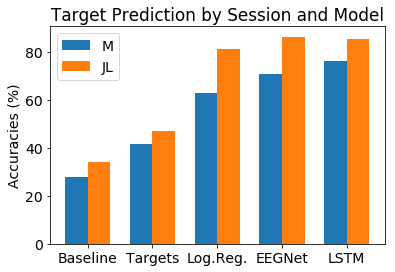

In [109]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['Baseline', 'Targets', 'Log.Reg.', 'EEGNet', 'LSTM']
accuracies = [[27.8, 41.6, 62.7, 70.6, 76.1],[34, 47, 81, 86.3, 85.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()

fig.savefig(str(datadir / 'converted' / ('Acc_Bars.png')))